In [1]:
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
pd.set_option('display.max_columns', None)
import os, requests, time
from google.colab import userdata
fred_api_key=userdata.get('FRED_API_KEY')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Explore the api (skip)

In [ ]:
BASE_URL = f"https://api.stlouisfed.org/fred/category/children?"
API_KEY=fred_api_key
store_list = []
count=0
DELAY=0.5
def fetch_all_categories(category_id, parent_name="ROOT" ):
  global count
  # if count>=50:
  #   return
  # print(f"FETCHING category {category_id} with depth {count}")
  params = {
      "api_key":API_KEY,
      "category_id": category_id,
      "file_type": "json"
  }
  response = requests.get(BASE_URL, params=params)
  if response.status_code == 200:
    data = response.json()
    children_categories = data.get('categories')
    for children_categorie in children_categories:
      # print(children_categorie)
      child_categori_id = children_categorie.get('id')
      child_name = children_categorie.get("name")
      store_list.append({
            "parent_id": children_categorie.get("parent_id"),
            "parent_name": parent_name,
            "category_id": child_categori_id,
            "name": children_categorie.get("name"),
            "notes": children_categorie.get("notes", "")
        })
      count+=1
      print(f"COUNT: {count} FETCHING child category {child_categori_id} from parent_cateogy {category_id}")
      # print(count)
      time.sleep(DELAY)
      fetch_all_categories(child_categori_id, child_name)
  else:
      print(f"Error: {response.status_code}, category: {category_id}")
      return

fetch_all_categories(0)
# print('STORE LIST ', store_list)
categories_df = pd.DataFrame(store_list)

In [ ]:
categories_df.to_csv("/content/drive/My Drive/freq_categories.csv", index=False)
drive.flush_and_unmount()

# FUNCTIONS

In [2]:
def get_children_categories(category_id, api_key, parent_name="ROOT" ):
  store_list=[]
  url="https://api.stlouisfed.org/fred/category/children?"
  params = {
      "api_key":api_key,
      "category_id": category_id,
      "file_type": "json"
  }
  response = requests.get(url, params=params)
  if response.status_code == 200:
    data = response.json()
    children_categories = data.get('categories')
    for children_categorie in children_categories:
      # print(children_categorie)
      child_categori_id = children_categorie.get('id')
      child_name = children_categorie.get("name")
      store_list.append({
            "parent_id": children_categorie.get("parent_id"),
            "parent_name": parent_name,
            "category_id": child_categori_id,
            "name": children_categorie.get("name"),
            "notes": children_categorie.get("notes", "")
        })
  else:
      print(f"Error: {response.status_code}, category: {category_id}")
      return
  df=pd.DataFrame.from_dict(store_list)
  print(df)

# get_children_categories(0, fred_api_key)

In [3]:
def search_series(search_name, api_key,frequency_criteria="Monthly"):
  SEARCH_URL = f"https://api.stlouisfed.org/fred/series/search?"
  store_list = []
  params = {
      "api_key":api_key,
      "search_text":search_name,
      "file_type": "json"
  }
  response = requests.get(SEARCH_URL, params=params)
  if response.status_code == 200:
    data = response.json()
    # print(data.get("count"))
    series=data.get("seriess")
    for serie in series:
      serie_id = serie.get("id")
      title = serie.get("title")
      frequency=serie.get("frequency")
      note = serie.get("notes")
      unit = serie.get("units")
      if frequency==frequency_criteria:
        store_list.append({"serie_id":serie_id,
                           "title":title,
                           "unit": unit,
                           "notes": note,
                           "seasonal_adjustment":serie.get("seasonal_adjustment")
                           })
  else:
      print(f"Error: {response.status_code}")
      return
  return pd.DataFrame(store_list)



In [4]:
def get_time_series(serie_id, api_key,start_time="1776-07-04", end_time="9999-12-31"):
  """return daily time point
  start time: 1776-07-04 is the earliest time
  end time: 9999-12-31 (latest available)
  """
  store_list = []
  URL = f"https://api.stlouisfed.org/fred/series/observations?"
  params = {
      "api_key":api_key,
      "series_id":serie_id,
      "file_type": "json",
      "observation_start": start_time,
      "observation_end": end_time,

  }
  response = requests.get(URL, params=params )
  if response.status_code == 200:
    data = response.json()
    observations = data.get("observations")
    for ob in observations:
      store_list.append({"Date":ob.get("date"), "Value":ob.get("value")})
  else:
      print(f"Error: {response.status_code}")
      return

  res_df = pd.DataFrame(store_list)
  #  Replace '.' with NaN
  res_df['Value'] = pd.to_numeric(res_df['Value'], errors='coerce')
  # Drop rows with NaN in 'value'
  res_df.dropna(subset=['Date','Value'], inplace=True)
  # set DatatimeIndex
  res_df['Date'] = pd.to_datetime(res_df['Date'])
  res_df['Value'] = res_df["Value"].astype(float)
  res_df = res_df.set_index('Date')
  return res_df


In [5]:
def get_serie_info(series_name, api_key):
  store_list = []
  URL = f"https://api.stlouisfed.org/fred/series?"
  params = {
      "api_key":api_key,
      "series_id":series_name,
      "file_type": "json",
  }
  response = requests.get(URL, params=params )
  if response.status_code == 200:
    data = response.json()
    data = data.get("seriess")[0]
    print( pd.DataFrame.from_dict(data, orient='index', columns=['Value']))
  else:
      print(f"Error: {response.status_code}")
      return
  return
get_serie_info("UNRATE", fred_api_key)


                                                                       Value
id                                                                    UNRATE
realtime_start                                                    2025-05-07
realtime_end                                                      2025-05-07
title                                                      Unemployment Rate
observation_start                                                 1948-01-01
observation_end                                                   2025-04-01
frequency                                                            Monthly
frequency_short                                                            M
units                                                                Percent
units_short                                                                %
seasonal_adjustment                                      Seasonally Adjusted
seasonal_adjustment_short                                                 SA

# Economic trend

## SP500 trend

In [7]:
sp500_df=get_time_series("SP500", fred_api_key)
sp500_df.shape

(2516, 1)

In [10]:
sp500_df.info()
sp500_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-06-01 to 2025-05-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


,Value
Date,
2015-06-01,2111.73
2015-06-02,2109.60
2015-06-03,2114.07
2015-06-04,2095.84
2015-06-05,2092.83


Text(0, 0.5, 'Value')

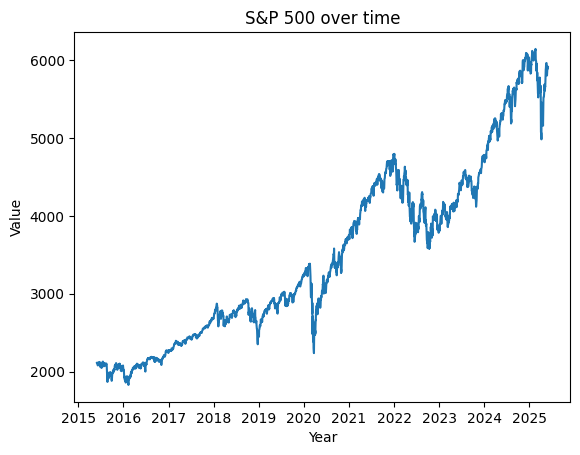

In [9]:
plt.plot(sp500_df.index, sp500_df.Value)
plt.title("S&P 500 over time")
plt.xlabel("Year")
plt.ylabel("Value")

## Unemployment and GDP trend over time

In [14]:
unrate_df=get_time_series("UNRATE", fred_api_key)
unrate_df.rename(columns={"Value":"Unemployment_Rate"}, inplace=True)
gdp_df = get_time_series("GDP", fred_api_key)
gdp_df.rename(columns={"Value":"GDP"}, inplace=True)
merge_df = pd.merge(unrate_df, gdp_df, on="Date")
print(unrate_df.shape, gdp_df.shape, merge_df.shape)

(928, 1) (313, 1) (309, 2)


In [15]:
merge_df.head()

,Unemployment_Rate,GDP
Date,,
1948-01-01,3.4,265.742
1948-04-01,3.9,272.567
1948-07-01,3.6,279.196
1948-10-01,3.7,280.366
1949-01-01,4.3,275.034


plot all the points

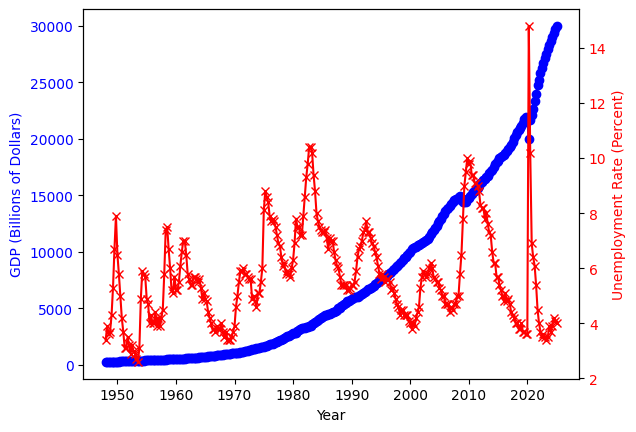

In [16]:
fig , ax1 = plt.subplots()
#plot GDP data
ax1.plot(merge_df.index, merge_df.GDP, color="blue", marker="o")
ax1.set_xlabel("Year")
ax1.set_ylabel("GDP (Billions of Dollars)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')
#second y-axis
ax2 = ax1.twinx()

ax2.plot(merge_df.index, merge_df.Unemployment_Rate, color="red", marker="x")
ax2.set_ylabel('Unemployment Rate (Percent)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# # Set x ticks every year
# ax1.xaxis.set_major_locator(mdates.YearLocator(1))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

plot on specific time interval

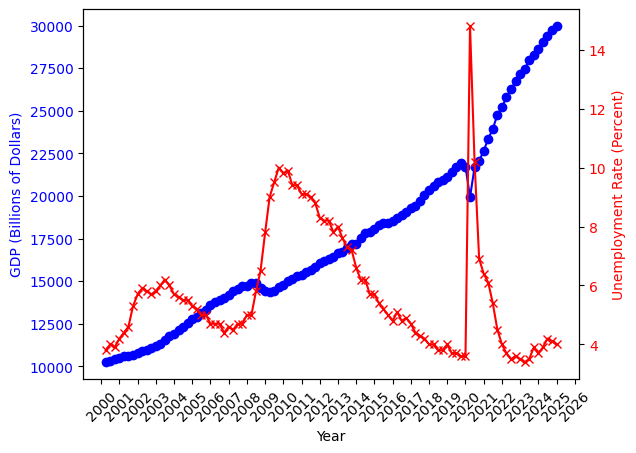

In [17]:
merge_df_=merge_df[merge_df.index>"2000"]
merge_df_.shape
fig , ax1 = plt.subplots()
#plot GDP data
ax1.plot(merge_df_.index, merge_df_.GDP, color="blue", marker="o")
ax1.set_xlabel("Year")
ax1.set_ylabel("GDP (Billions of Dollars)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')


# Rotate x-axis tick labels 90 degrees
for label in ax1.get_xticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment('center')
#second y-axis
ax2 = ax1.twinx()
ax2.plot(merge_df_.index, merge_df_.Unemployment_Rate, color="red", marker="x")
ax2.set_ylabel('Unemployment Rate (Percent)', color='red')
ax2.tick_params(axis='y', labelcolor='red')


# Set x ticks every year
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

## Unemployment by States

### get series name to analyze

In [18]:
unemployment_series_df = search_series("unemployment", fred_api_key, "Monthly" )
unemployment_series_df.shape

(206, 5)

In [19]:
unemployment_series_filter_df = unemployment_series_df[(unemployment_series_df.title.str.contains("Unemployment Rate in", case=False))
 & (unemployment_series_df.seasonal_adjustment=="Seasonally Adjusted") & (unemployment_series_df.serie_id.str.endswith("R"))]
unemployment_series_filter_df['State'] = unemployment_series_filter_df.title.str.replace("Unemployment Rate in ","")
unemployment_series_filter_df.head()

<ipython-input-19-5993c87b816f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unemployment_series_filter_df['State'] = unemployment_series_filter_df.title.str.replace("Unemployment Rate in ","")


,serie_id,title,unit,notes,seasonal_adjustment,State
7,CAUR,Unemployment Rate in California,Percent,None,Seasonally Adjusted,California
10,TXUR,Unemployment Rate in Texas,Percent,None,Seasonally Adjusted,Texas
17,NYUR,Unemployment Rate in New York,Percent,None,Seasonally Adjusted,New York
21,FLUR,Unemployment Rate in Florida,Percent,None,Seasonally Adjusted,Florida
43,PAUR,Unemployment Rate in Pennsylvania,Percent,None,Seasonally Adjusted,Pennsylvania


In [20]:
unemployment_df=pd.DataFrame()
for _, row in unemployment_series_filter_df.iterrows():
  serie_id, state = row['serie_id'], row['State']
  cur_time_serie_df = get_time_series(serie_id, fred_api_key)
  cur_time_serie_df['State']=state
  unemployment_df=pd.concat([unemployment_df, cur_time_serie_df])
  # print(unemployment_df.shape)
  time.sleep(0.5)

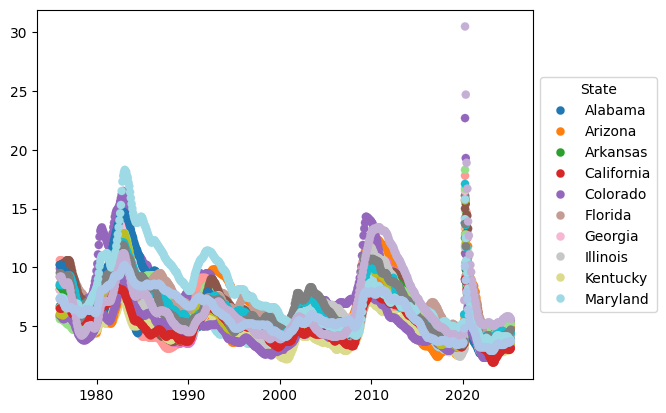

In [27]:
state_codes = unemployment_df.State.astype('category')
codes = state_codes.cat.codes
fig, ax = plt.subplots()
scatter = ax.scatter(unemployment_df.index, unemployment_df.Value, c=codes, cmap='tab20')

handles, _ = scatter.legend_elements()
legend_labels = state_codes.cat.categories
ax.legend(handles, legend_labels, title="State", loc='center left',bbox_to_anchor=(1, 0.5) )
plt.show()

### Animation showing unemployement rate by state over time (SKIP FOR NOW)

In [98]:
from matplotlib.animation import FuncAnimation

In [ ]:
unemployment_df = unemployment_df.sort_index()
time_intervals =unemployment_df.index
fig, ax = plt.subplots()

def animate(time_index):
  ax.clear()
  cur_df = unemployment_df.loc[time_index]
  ax.barh(cur_df['State'], cur_df['Value'], color='skyblue')

# Create animation
anim = FuncAnimation(
    fig,
    animate,
    frames=time_intervals,
     interval=50, repeat=False
)
anim.save('animation.mp4', writer='ffmpeg')
plt.tight_layout()
plt.show()